In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/iterative-stratification/iterative-stratification-master/.gitignore
/kaggle/input/iterative-stratification/iterative-stratification-master/LICENSE
/kaggle/input/iterative-stratification/iterative-stratification-master/setup.py
/kaggle/input/iterative-stratification/iterative-stratification-master/setup.cfg
/kaggle/input/iterative-stratification/iterative-stratification-master/.travis.yml
/kaggle/input/iterative-stratification/iterative-stratification-master/README.md
/kaggle/input/iterative-stratification/iterative-stratification-master/tests/__init__.py
/kaggle/input/iterative-stratification/iterative-stratification-master/tests/test_ml_stratifiers.py
/kaggle/input/iterative-stratification/iterative-stratification-master/iterstrat/ml_stratifiers.py
/kaggle/input/iterative-stratification/iterative-stratification-master/iterstrat/__init__.py
/kaggle/input/lish-moa/train_features.csv
/kaggle/input/lish-moa/test_features.csv
/kaggle/input/lish-moa/train_targets_nonscored.csv

In [2]:
import sys
sys.path.insert(1, '/kaggle/input/permutation-importance')
sys.path.insert(2, '/kaggle/input/iterative-stratification/iterative-stratification-master')

## Import Packages

In [3]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow_addons.optimizers import AdamW, Lookahead
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils  import plot_model
from PermutationImportance import PermutationImportance

/opt/conda/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


## Helper Functions

In [4]:
def logloss_metric(df, y_true, y_pred):
    
    metrics = []
    
    # Calculate log_loss individually for every field
    for _target in df.columns:
        metrics.append(log_loss(y_true.loc[:, _target], 
                                y_pred.loc[:, _target].astype(float), 
                                labels=[0,1]))
    
    # Return mean of individual log_loss values
    return np.mean(metrics)

In [5]:
def data_preprocess(train_df, predict_df):
    
    # Display individual dataframe shapes
    print("train_df: {}".format(train_df.shape))
    print("predict_df: {}".format(predict_df.shape))
    train_samples = train_df.shape[0]
    
    # Combined both input dataframes
    combined_df = train_df.append(predict_df, sort=False, ignore_index=True)
    
    # Feature Engineering
    combined_df['cp_type_enc'] = combined_df['cp_type'].map({'trt_cp': 0, 'ctl_vehicle': 1})
    combined_df['cp_dose_enc'] = combined_df['cp_dose'].map({'D1': 0, 'D2': 1})
    combined_df['cp_time_days'] = combined_df['cp_time'].apply(lambda x: x//24)
    combined_df.drop(['sig_id', 'cp_type', 'cp_dose', 'cp_time'], axis=1, inplace=True)
    
    # Segregate train and predict datasets
    train_x = combined_df[:train_samples].values
    predict_x = combined_df[train_samples:].values
    print("train_x: {}".format(train_x.shape))
    print("predict_x: {}".format(predict_x.shape))
    
    return train_x, predict_x

In [6]:
def moa_prediction_model(input_shape, output_shape):
    
    # Input Layer
    x_input = Input(shape=(input_shape, ), name='INPUT')
    x = BatchNormalization(name='BN-INPUT')(x_input)
    
    # Fully-connected Layer 1
    x = Dense(units=2048, name='FC-1', activation='relu', kernel_regularizer=l2(0.0005))(x)
    x = BatchNormalization(name='BN_FC-1')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-1')(x)
    
    # Fully-connected Layer 2
    x = Dense(units=512, name='FC-2', activation='relu', kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization(name='BN_FC-2')(x)
    x = Dropout(rate=0.5, name='DROPOUT_FC-2')(x)
    
    # Output Layer
    x = Dense(units=output_shape, activation='sigmoid', name='OUTPUT')(x)

    # Create Keras Model instance
    model = Model(inputs=x_input, outputs=x, name='MOA_Prediction_Model')

    return model

## Unscored Dataset

### Data Preprocessing

In [7]:
# Set file paths for train and predict datasets
train_dataset = "/kaggle/input/lish-moa/train_features.csv"
train_labels = "/kaggle/input/lish-moa/train_targets_nonscored.csv"
predict_dataset = "/kaggle/input/lish-moa/test_features.csv"

In [8]:
# Process train and predict features datasets
train_df = pd.read_csv(train_dataset)
train_label_df = pd.read_csv(train_labels)
predict_df = pd.read_csv(predict_dataset)

print("train_df: {}".format(train_df.shape))
print("train_label_df: {}".format(train_label_df.shape))
print("predict_df: {}".format(predict_df.shape))

train_df: (23814, 876)
train_label_df: (23814, 403)
predict_df: (3982, 876)


In [9]:
# Remove rows with cp_type='ctl_vehicle'
train_label_df = train_label_df.loc[train_df['cp_type']=='trt_cp'].reset_index(drop=True)
train_df = train_df.loc[train_df['cp_type']=='trt_cp'].reset_index(drop=True)

print("train_label_df: {}".format(train_label_df.shape))
print("train_df: {}".format(train_df.shape))

train_label_df: (21948, 403)
train_df: (21948, 876)


In [10]:
# Remove 'sig_id' column
train_label_df.drop(['sig_id'], axis=1, inplace=True)
train_y = train_label_df.values
print("train_y: {}".format(train_y.shape))
train_label_df.head()

train_y: (21948, 402)


,abc_transporter_expression_enhancer,abl_inhibitor,ace_inhibitor,acetylcholine_release_enhancer,adenosine_deaminase_inhibitor,adenosine_kinase_inhibitor,adenylyl_cyclase_inhibitor,age_inhibitor,alcohol_dehydrogenase_inhibitor,aldehyde_dehydrogenase_activator,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
train_x, Xpredict = data_preprocess(train_df, predict_df)

train_df: (21948, 876)
predict_df: (3982, 876)
train_x: (21948, 875)
predict_x: (3982, 875)


### Feature Selection

In [12]:

# Prepare datasets for training
Xtrain = train_x.copy()
Ytrain = train_y.copy()


# Define the model hyperparameters
mini_batch_size = 128
perm_imp = np.zeros(Xtrain.shape[1])


# Define K-fold cross validation test harness
kfold = MultilabelStratifiedKFold(n_splits=7, shuffle=True, random_state=50)

for idx, (train, val) in enumerate(kfold.split(Xtrain, Ytrain)):
    
    print("\n---------------- Fold {} ----------------".format(idx))
    
    train_x_tmp, val_x_tmp = Xtrain[train], Xtrain[val]
    train_y_tmp, val_y_tmp = Ytrain[train], Ytrain[val]
    
    # Create the model
    model = moa_prediction_model(Xtrain.shape[1], Ytrain.shape[1])

    # Compile model to configure the learning process
    model.compile(loss='binary_crossentropy', 
                  optimizer=Lookahead(AdamW(lr=1e-2, 
                                            weight_decay=1e-5, 
                                            clipvalue=700), 
                                      sync_period=10))
    
    # Early stopping policy
    early = EarlyStopping(monitor="val_loss", mode="min", 
                          restore_best_weights=True, 
                          patience=7, verbose=1)
    
    # Reduce LR on plateau policy
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, 
                                  min_lr=1e-5, patience=5, 
                                  verbose=1, mode='min')
    
    # Fit the model
    history = model.fit(x=train_x_tmp, y=train_y_tmp, 
                        batch_size=mini_batch_size, epochs=85, verbose=1,
                        callbacks=[reduce_lr, early], workers=5,
                        validation_data=(val_x_tmp, val_y_tmp))
    
    fet_imp = PermutationImportance(model, val_x_tmp, val_y_tmp, n_iter=1, random_state=50)
    _, local_imp = fet_imp.get_score_importances()
    perm_imp += np.mean(local_imp, axis=0)


top_feats = np.argwhere(perm_imp < 0).flatten()
print(len(top_feats))



---------------- Fold 0 ----------------
Epoch 1/85
147/147 [==============================] - 1s 9ms/step - loss: 0.3152 - val_loss: 0.0590
Epoch 2/85
147/147 [==============================] - 1s 7ms/step - loss: 0.1670 - val_loss: 0.7570
Epoch 3/85
147/147 [==============================] - 1s 7ms/step - loss: 0.1389 - val_loss: 0.1500
Epoch 4/85
147/147 [==============================] - 1s 9ms/step - loss: 0.2606 - val_loss: 0.0445
Epoch 5/85
147/147 [==============================] - 1s 8ms/step - loss: 0.0361 - val_loss: 0.0145
Epoch 6/85
147/147 [==============================] - 1s 8ms/step - loss: 0.1042 - val_loss: 0.0307
Epoch 7/85
147/147 [==============================] - 1s 7ms/step - loss: 0.1423 - val_loss: 0.0608
Epoch 8/85
147/147 [==============================] - 1s 7ms/step - loss: 0.0312 - val_loss: 0.0312
Epoch 9/85
147/147 [==============================] - 1s 7ms/step - loss: 0.0559 - val_loss: 0.0523
Epoch 10/85
147/147 [==============================] - 1s 

100%|██████████| 875/875 [05:54<00:00,  2.47it/s]



---------------- Fold 1 ----------------
Epoch 1/85
147/147 [==============================] - 1s 8ms/step - loss: 0.3094 - val_loss: 0.0436
Epoch 2/85
147/147 [==============================] - 1s 9ms/step - loss: 0.1368 - val_loss: 0.1083
Epoch 3/85
147/147 [==============================] - 1s 9ms/step - loss: 0.2458 - val_loss: 0.4738
Epoch 4/85
147/147 [==============================] - 1s 7ms/step - loss: 0.1149 - val_loss: 0.0459
Epoch 5/85
147/147 [==============================] - 1s 7ms/step - loss: 0.0795 - val_loss: 0.1184
Epoch 6/85
144/147 [============================>.] - ETA: 0s - loss: 0.1412
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
147/147 [==============================] - 1s 7ms/step - loss: 0.1488 - val_loss: 0.4722
Epoch 7/85
147/147 [==============================] - 1s 7ms/step - loss: 0.3551 - val_loss: 0.2469
Epoch 8/85
147/147 [==============================] - 1s 9ms/step - loss: 0.1924 - val_loss: 0.1508
Epoch 00008:

100%|██████████| 875/875 [05:49<00:00,  2.50it/s]



---------------- Fold 2 ----------------
Epoch 1/85
147/147 [==============================] - 1s 8ms/step - loss: 0.3075 - val_loss: 0.1579
Epoch 2/85
147/147 [==============================] - 1s 9ms/step - loss: 0.1465 - val_loss: 0.0386
Epoch 3/85
147/147 [==============================] - 1s 10ms/step - loss: 0.0546 - val_loss: 0.0524
Epoch 4/85
147/147 [==============================] - 1s 8ms/step - loss: 0.1577 - val_loss: 0.1641
Epoch 5/85
147/147 [==============================] - 1s 7ms/step - loss: 0.0652 - val_loss: 0.0225
Epoch 6/85
147/147 [==============================] - 1s 7ms/step - loss: 0.0640 - val_loss: 0.0157
Epoch 7/85
147/147 [==============================] - 1s 7ms/step - loss: 0.0605 - val_loss: 0.0185
Epoch 8/85
147/147 [==============================] - 1s 9ms/step - loss: 0.1085 - val_loss: 0.2033
Epoch 9/85
147/147 [==============================] - 1s 8ms/step - loss: 0.0532 - val_loss: 0.0191
Epoch 10/85
147/147 [==============================] - 1s

100%|██████████| 875/875 [05:38<00:00,  2.59it/s]



---------------- Fold 3 ----------------
Epoch 1/85
147/147 [==============================] - 2s 11ms/step - loss: 0.2959 - val_loss: 0.0440
Epoch 2/85
147/147 [==============================] - 1s 9ms/step - loss: 0.2756 - val_loss: 0.1759
Epoch 3/85
147/147 [==============================] - 2s 10ms/step - loss: 0.0930 - val_loss: 0.0325
Epoch 4/85
147/147 [==============================] - 1s 8ms/step - loss: 0.1136 - val_loss: 0.0152
Epoch 5/85
147/147 [==============================] - 1s 7ms/step - loss: 0.0797 - val_loss: 0.2757
Epoch 6/85
147/147 [==============================] - 1s 7ms/step - loss: 0.1240 - val_loss: 0.0163
Epoch 7/85
147/147 [==============================] - 1s 8ms/step - loss: 0.0152 - val_loss: 0.0244
Epoch 8/85
147/147 [==============================] - 1s 7ms/step - loss: 0.0814 - val_loss: 0.0653
Epoch 9/85
145/147 [============================>.] - ETA: 0s - loss: 0.0279
Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

100%|██████████| 875/875 [05:46<00:00,  2.52it/s]



---------------- Fold 4 ----------------
Epoch 1/85
147/147 [==============================] - 1s 8ms/step - loss: 0.3338 - val_loss: 0.1469
Epoch 2/85
147/147 [==============================] - 1s 7ms/step - loss: 0.1290 - val_loss: 0.4124
Epoch 3/85
147/147 [==============================] - 1s 7ms/step - loss: 0.1411 - val_loss: 0.0252
Epoch 4/85
147/147 [==============================] - 1s 7ms/step - loss: 0.2596 - val_loss: 0.0526
Epoch 5/85
147/147 [==============================] - 1s 7ms/step - loss: 0.0388 - val_loss: 0.0178
Epoch 6/85
147/147 [==============================] - 1s 7ms/step - loss: 0.0293 - val_loss: 0.0216
Epoch 7/85
147/147 [==============================] - 1s 7ms/step - loss: 0.0239 - val_loss: 0.0143
Epoch 8/85
147/147 [==============================] - 1s 7ms/step - loss: 0.1613 - val_loss: 0.2778
Epoch 9/85
147/147 [==============================] - 1s 8ms/step - loss: 0.0692 - val_loss: 0.0193
Epoch 10/85
147/147 [==============================] - 1s 

100%|██████████| 875/875 [05:49<00:00,  2.50it/s]



---------------- Fold 5 ----------------
Epoch 1/85
147/147 [==============================] - 1s 8ms/step - loss: 0.3236 - val_loss: 0.1310
Epoch 2/85
147/147 [==============================] - 1s 7ms/step - loss: 0.1451 - val_loss: 0.0537
Epoch 3/85
147/147 [==============================] - 1s 8ms/step - loss: 0.1003 - val_loss: 0.0265
Epoch 4/85
147/147 [==============================] - 1s 7ms/step - loss: 0.2731 - val_loss: 0.0800
Epoch 5/85
147/147 [==============================] - 1s 7ms/step - loss: 0.1672 - val_loss: 0.1619
Epoch 6/85
147/147 [==============================] - 1s 7ms/step - loss: 0.0707 - val_loss: 0.2628
Epoch 7/85
147/147 [==============================] - 1s 9ms/step - loss: 0.0698 - val_loss: 0.0691
Epoch 8/85
143/147 [============================>.] - ETA: 0s - loss: 0.0910
Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
147/147 [==============================] - 1s 7ms/step - loss: 0.1035 - val_loss: 0.5145
Epoch 9/85
1

100%|██████████| 875/875 [05:47<00:00,  2.52it/s]



---------------- Fold 6 ----------------
Epoch 1/85
147/147 [==============================] - 1s 9ms/step - loss: 0.3178 - val_loss: 0.0541
Epoch 2/85
147/147 [==============================] - 1s 9ms/step - loss: 0.1723 - val_loss: 0.0717
Epoch 3/85
147/147 [==============================] - 1s 9ms/step - loss: 0.0679 - val_loss: 0.0516
Epoch 4/85
147/147 [==============================] - 1s 9ms/step - loss: 0.2293 - val_loss: 0.4465
Epoch 5/85
147/147 [==============================] - 1s 9ms/step - loss: 0.1304 - val_loss: 0.0208
Epoch 6/85
147/147 [==============================] - 1s 10ms/step - loss: 0.0359 - val_loss: 0.0318
Epoch 7/85
147/147 [==============================] - 1s 10ms/step - loss: 0.0256 - val_loss: 0.0167
Epoch 8/85
147/147 [==============================] - 1s 8ms/step - loss: 0.1259 - val_loss: 0.0793
Epoch 9/85
147/147 [==============================] - 1s 7ms/step - loss: 0.0379 - val_loss: 0.0187
Epoch 10/85
147/147 [==============================] - 1

100%|██████████| 875/875 [05:58<00:00,  2.44it/s]

722


In [13]:
top_feats

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  24,  25,  26,  27,
        28,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  45,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
        57,  58,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
        71,  72,  73,  75,  76,  77,  78,  79,  80,  81,  82,  84,  85,
        87,  88,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100,
       101, 102, 103, 104, 105, 106, 107, 108, 110, 112, 113, 117, 120,
       121, 122, 123, 124, 127, 128, 129, 130, 131, 132, 133, 134, 135,
       136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 147, 148, 149,
       150, 151, 152, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163,
       164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 175, 176, 177,
       178, 179, 180, 181, 182, 183, 184, 185, 187, 188, 189, 190, 191,
       192, 193, 195, 196, 197, 199, 200, 201, 202, 203, 204, 20

In [14]:
'''
top_feats = 

print(len(top_feats))
'''

'\ntop_feats = \n\nprint(len(top_feats))\n'

### Split training data into train / test datasets

In [15]:
sss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.085, random_state=10)
for train_index, test_index in sss.split(train_x, train_y):
    Xtrain, Xtest = train_x[train_index], train_x[test_index]
    Ytrain, Ytest = train_y[train_index], train_y[test_index]

In [16]:
Xtrain_full = train_x[:, top_feats].copy()
Xtrain = Xtrain[:, top_feats]
Xtest = Xtest[:, top_feats]
Xpredict = Xpredict[:, top_feats]

print("------------------------- Training Dataset -------------------------")
print("Xtrain_full shape: {}".format(Xtrain_full.shape))
print("Xtrain shape: {}".format(Xtrain.shape))
print("Ytrain shape: {}".format(Ytrain.shape))

print("\n------------------------- Test Dataset -------------------------")
print("Xtest shape: {}".format(Xtest.shape))
print("Ytest shape: {}".format(Ytest.shape))

print("\n------------------------- Prediction Dataset -------------------------")
print("Xpredict shape: {}".format(Xpredict.shape))

------------------------- Training Dataset -------------------------
Xtrain_full shape: (21948, 722)
Xtrain shape: (20082, 722)
Ytrain shape: (20082, 402)

------------------------- Test Dataset -------------------------
Xtest shape: (1866, 722)
Ytest shape: (1866, 402)

------------------------- Prediction Dataset -------------------------
Xpredict shape: (3982, 722)


### Build and validate the model

In [17]:
# Define the model hyperparameters
mini_batch_size = 128

# Prediction Clipping Thresholds
p_min = 0.001
p_max = 0.999

# Create the model
model = moa_prediction_model(Xtrain.shape[1], Ytrain.shape[1])
model.summary()

Model: "MOA_Prediction_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           [(None, 722)]             0         
_________________________________________________________________
BN-INPUT (BatchNormalization (None, 722)               2888      
_________________________________________________________________
FC-1 (Dense)                 (None, 2048)              1480704   
_________________________________________________________________
BN_FC-1 (BatchNormalization) (None, 2048)              8192      
_________________________________________________________________
DROPOUT_FC-1 (Dropout)       (None, 2048)              0         
_________________________________________________________________
FC-2 (Dense)                 (None, 512)               1049088   
_________________________________________________________________
BN_FC-2 (BatchNormalization) (None, 512)      

In [18]:
y_pred_train = 0
y_pred_val = 0
y_pred_final = 0
idx = 0

np.random.seed(1)
seeds = np.random.randint(0, 100, size=5)

for seed in seeds:
    
    # Define K-fold cross validation test harness
    kfold = MultilabelStratifiedKFold(n_splits=7, shuffle=True, random_state=seed)
    
    for train, val in kfold.split(Xtrain, Ytrain):

        idx += 1
        print("---------------- Fold {} ----------------".format(idx))

        train_x_tmp, val_x_tmp = Xtrain[train], Xtrain[val]
        train_y_tmp, val_y_tmp = Ytrain[train], Ytrain[val]

        # Create the model
        model = moa_prediction_model(Xtrain.shape[1], Ytrain.shape[1])

        # Compile model to configure the learning process
        model.compile(loss='binary_crossentropy', 
                      optimizer=Lookahead(AdamW(lr=1e-2, 
                                                weight_decay=1e-5, 
                                                clipvalue=700), 
                                          sync_period=10))

        # Early stopping policy
        early = EarlyStopping(monitor="val_loss", mode="min", 
                              restore_best_weights=True, 
                              patience=10, verbose=1)

        # Reduce LR on plateau policy
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, 
                                      min_lr=1e-5, patience=5, 
                                      verbose=1, mode='min')

        # Fit the model
        history = model.fit(x=train_x_tmp, y=train_y_tmp, 
                            batch_size=mini_batch_size, epochs=85, verbose=1,
                            callbacks=[reduce_lr, early], workers=5,
                            validation_data=(val_x_tmp, val_y_tmp))

        # Make predictions
        pred_val = model.predict(Xtest)
        y_pred_val += pred_val
        
        pred_train = model.predict(Xtrain_full)
        y_pred_train += pred_train

        pred_final = model.predict(Xpredict)
        y_pred_final += pred_final


print("Total #iterations: {}".format(idx))
y_pred_val /= float(idx)
y_pred_train /= float(idx)
y_pred_final /= float(idx)

---------------- Fold 1 ----------------
Epoch 1/85
135/135 [==============================] - 1s 9ms/step - loss: 0.3353 - val_loss: 0.2809
Epoch 2/85
135/135 [==============================] - 1s 9ms/step - loss: 0.1503 - val_loss: 0.2034
Epoch 3/85
135/135 [==============================] - 1s 7ms/step - loss: 0.1880 - val_loss: 0.0281
Epoch 4/85
135/135 [==============================] - 1s 7ms/step - loss: 0.0277 - val_loss: 0.0382
Epoch 5/85
135/135 [==============================] - 1s 7ms/step - loss: 0.0244 - val_loss: 0.0137
Epoch 6/85
135/135 [==============================] - 1s 7ms/step - loss: 0.0205 - val_loss: 0.0345
Epoch 7/85
135/135 [==============================] - 1s 7ms/step - loss: 0.3422 - val_loss: 0.1503
Epoch 8/85
135/135 [==============================] - 1s 9ms/step - loss: 0.0779 - val_loss: 0.0378
Epoch 9/85
135/135 [==============================] - 1s 7ms/step - loss: 0.0235 - val_loss: 0.0138
Epoch 10/85
129/135 [===========================>..] - ETA:

In [19]:
# Label smoothing
y_pred_val = np.clip(y_pred_val, p_min, p_max)
y_pred_train = np.clip(y_pred_train, p_min, p_max)
y_pred_final = np.clip(y_pred_final, p_min, p_max)

In [20]:
# Validate the model
true_labels = pd.DataFrame(Ytest, columns=train_label_df.columns)
pred_labels = pd.DataFrame(y_pred_val, columns=train_label_df.columns)
logloss_metric(train_label_df, true_labels, pred_labels)

0.005194666970553282

In [21]:
# Create unscored train dataframes for next step
train_label_unscored_df = pd.DataFrame(y_pred_train, columns=train_label_df.columns)
train_label_unscored_df['sig_id'] = train_df['sig_id']
train_label_unscored_df.head()

,abc_transporter_expression_enhancer,abl_inhibitor,ace_inhibitor,acetylcholine_release_enhancer,adenosine_deaminase_inhibitor,adenosine_kinase_inhibitor,adenylyl_cyclase_inhibitor,age_inhibitor,alcohol_dehydrogenase_inhibitor,aldehyde_dehydrogenase_activator,...,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor,sig_id
0,0.001,0.001,0.004444,0.001,0.001,0.001,0.001,0.001000,0.001,0.001,...,0.001,0.001000,0.001,0.00100,0.001000,0.001,0.001,0.001000,0.001,id_000644bb2
1,0.001,0.001,0.005681,0.001,0.001,0.001,0.001,0.001000,0.001,0.001,...,0.001,0.001114,0.001,0.00100,0.001000,0.001,0.001,0.001231,0.001,id_000779bfc
2,0.001,0.001,0.001312,0.001,0.001,0.001,0.001,0.001000,0.001,0.001,...,0.001,0.001000,0.001,0.00111,0.001000,0.001,0.001,0.001000,0.001,id_000a6266a
3,0.001,0.001,0.001014,0.001,0.001,0.001,0.001,0.001000,0.001,0.001,...,0.001,0.001000,0.001,0.00100,0.001000,0.001,0.001,0.001000,0.001,id_0015fd391
4,0.001,0.001,0.008396,0.001,0.001,0.001,0.001,0.001738,0.001,0.001,...,0.001,0.001163,0.001,0.00122,0.001002,0.001,0.001,0.002459,0.001,id_001626bd3


In [22]:
# Create unscored predict dataframes for next step
pred_labels_unscored_df = pd.DataFrame(y_pred_final, columns=train_label_df.columns)
pred_labels_unscored_df.loc[predict_df['cp_type']=='ctl_vehicle', train_label_df.columns] = 0
pred_labels_unscored_df['sig_id'] = predict_df['sig_id']
pred_labels_unscored_df.head()

,abc_transporter_expression_enhancer,abl_inhibitor,ace_inhibitor,acetylcholine_release_enhancer,adenosine_deaminase_inhibitor,adenosine_kinase_inhibitor,adenylyl_cyclase_inhibitor,age_inhibitor,alcohol_dehydrogenase_inhibitor,aldehyde_dehydrogenase_activator,...,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor,sig_id
0,0.001,0.001000,0.003472,0.001,0.001,0.001,0.001,0.001000,0.001,0.001,...,0.001,0.001,0.001,0.001372,0.001043,0.001,0.001,0.001058,0.001,id_0004d9e33
1,0.001,0.008222,0.001503,0.001,0.001,0.001,0.001,0.001000,0.001,0.001,...,0.001,0.001,0.001,0.001000,0.001000,0.001,0.001,0.001000,0.001,id_001897cda
2,0.000,0.000000,0.000000,0.000,0.000,0.000,0.000,0.000000,0.000,0.000,...,0.000,0.000,0.000,0.000000,0.000000,0.000,0.000,0.000000,0.000,id_002429b5b
3,0.001,0.001000,0.001373,0.001,0.001,0.001,0.001,0.001000,0.001,0.001,...,0.001,0.001,0.001,0.001000,0.001000,0.001,0.001,0.001000,0.001,id_00276f245
4,0.001,0.001000,0.007461,0.001,0.001,0.001,0.001,0.001024,0.001,0.001,...,0.001,0.001,0.001,0.001000,0.001000,0.001,0.001,0.002504,0.001,id_0027f1083


## Scored Dataset

### Data Preprocessing

In [23]:
# Set file paths for train and predict datasets
train_dataset = "/kaggle/input/lish-moa/train_features.csv"
train_labels = "/kaggle/input/lish-moa/train_targets_scored.csv"
predict_dataset = "/kaggle/input/lish-moa/test_features.csv"

In [24]:
# Process train and predict features datasets
train_df = pd.read_csv(train_dataset)
train_label_df = pd.read_csv(train_labels)
predict_df = pd.read_csv(predict_dataset)

print("train_df: {}".format(train_df.shape))
print("train_label_df: {}".format(train_label_df.shape))
print("predict_df: {}".format(predict_df.shape))

train_df: (23814, 876)
train_label_df: (23814, 207)
predict_df: (3982, 876)


In [25]:
train_label_df = train_label_df.loc[train_df['cp_type']=='trt_cp'].reset_index(drop=True)
train_df = train_df.loc[train_df['cp_type']=='trt_cp'].reset_index(drop=True)

print("train_label_df: {}".format(train_label_df.shape))
print("train_df: {}".format(train_df.shape))

train_label_df: (21948, 207)
train_df: (21948, 876)


In [26]:
train_df = pd.merge(train_df, train_label_unscored_df, 
                    how='inner', on='sig_id')
print("train_df: {}".format(train_df.shape))
train_df.head()

train_df: (21948, 1278)


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.001,0.001,0.001000,0.001,0.00100,0.001000,0.001,0.001,0.001000,0.001
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,0.001,0.001,0.001114,0.001,0.00100,0.001000,0.001,0.001,0.001231,0.001
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,0.001,0.001,0.001000,0.001,0.00111,0.001000,0.001,0.001,0.001000,0.001
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,0.001,0.001,0.001000,0.001,0.00100,0.001000,0.001,0.001,0.001000,0.001
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.001,0.001,0.001163,0.001,0.00122,0.001002,0.001,0.001,0.002459,0.001


In [27]:
predict_df = pd.merge(predict_df, pred_labels_unscored_df, 
                      how='inner', on='sig_id')
print("predict_df: {}".format(predict_df.shape))
predict_df.head()

predict_df: (3982, 1278)


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_0004d9e33,trt_cp,24,D1,-0.5458,0.1306,-0.5135,0.4408,1.5500,-0.1644,...,0.001,0.001,0.001,0.001,0.001372,0.001043,0.001,0.001,0.001058,0.001
1,id_001897cda,trt_cp,72,D1,-0.1829,0.2320,1.2080,-0.4522,-0.3652,-0.3319,...,0.001,0.001,0.001,0.001,0.001000,0.001000,0.001,0.001,0.001000,0.001
2,id_002429b5b,ctl_vehicle,24,D1,0.1852,-0.1404,-0.3911,0.1310,-1.4380,0.2455,...,0.000,0.000,0.000,0.000,0.000000,0.000000,0.000,0.000,0.000000,0.000
3,id_00276f245,trt_cp,24,D2,0.4828,0.1955,0.3825,0.4244,-0.5855,-1.2020,...,0.001,0.001,0.001,0.001,0.001000,0.001000,0.001,0.001,0.001000,0.001
4,id_0027f1083,trt_cp,48,D1,-0.3979,-1.2680,1.9130,0.2057,-0.5864,-0.0166,...,0.001,0.001,0.001,0.001,0.001000,0.001000,0.001,0.001,0.002504,0.001


In [28]:
train_label_df.drop(['sig_id'], axis=1, inplace=True)
train_y = train_label_df.values
print("train_y: {}".format(train_y.shape))
train_label_df.head()

train_y: (21948, 206)


,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
train_x, Xpredict = data_preprocess(train_df, predict_df)

train_df: (21948, 1278)
predict_df: (3982, 1278)
train_x: (21948, 1277)
predict_x: (3982, 1277)


### Feature Selection

In [30]:

# Prepare datasets for training
Xtrain = train_x.copy()
Ytrain = train_y.copy()


# Define the model hyperparameters
mini_batch_size = 128
perm_imp = np.zeros(Xtrain.shape[1])


# Define K-fold cross validation test harness
kfold = MultilabelStratifiedKFold(n_splits=7, shuffle=True, random_state=50)

for idx, (train, val) in enumerate(kfold.split(Xtrain, Ytrain)):
    
    print("\n---------------- Fold {} ----------------".format(idx))
    
    train_x_tmp, val_x_tmp = Xtrain[train], Xtrain[val]
    train_y_tmp, val_y_tmp = Ytrain[train], Ytrain[val]
    
    # Create the model
    model = moa_prediction_model(Xtrain.shape[1], Ytrain.shape[1])

    # Compile model to configure the learning process
    model.compile(loss='binary_crossentropy', 
                  optimizer=Lookahead(AdamW(lr=1e-2, 
                                            weight_decay=1e-5, 
                                            clipvalue=700), 
                                      sync_period=10))
    
    # Early stopping policy
    early = EarlyStopping(monitor="val_loss", mode="min", 
                          restore_best_weights=True, 
                          patience=7, verbose=1)
    
    # Reduce LR on plateau policy
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, 
                                  min_lr=1e-5, patience=5, 
                                  verbose=1, mode='min')
    
    # Fit the model
    history = model.fit(x=train_x_tmp, y=train_y_tmp, 
                        batch_size=mini_batch_size, epochs=85, verbose=1,
                        callbacks=[reduce_lr, early], workers=5,
                        validation_data=(val_x_tmp, val_y_tmp))
    
    fet_imp = PermutationImportance(model, val_x_tmp, val_y_tmp, n_iter=1, random_state=50)
    _, local_imp = fet_imp.get_score_importances()
    perm_imp += np.mean(local_imp, axis=0)


top_feats = np.argwhere(perm_imp < 0).flatten()
print(len(top_feats))



---------------- Fold 0 ----------------
Epoch 1/85
147/147 [==============================] - 1s 10ms/step - loss: 0.3418 - val_loss: 0.1317
Epoch 2/85
147/147 [==============================] - 1s 7ms/step - loss: 0.1262 - val_loss: 0.0585
Epoch 3/85
147/147 [==============================] - 1s 7ms/step - loss: 0.1885 - val_loss: 0.1489
Epoch 4/85
147/147 [==============================] - 1s 7ms/step - loss: 0.0630 - val_loss: 0.0544
Epoch 5/85
147/147 [==============================] - 1s 7ms/step - loss: 0.0764 - val_loss: 0.0654
Epoch 6/85
147/147 [==============================] - 1s 7ms/step - loss: 0.0534 - val_loss: 0.0431
Epoch 7/85
147/147 [==============================] - 1s 7ms/step - loss: 0.0663 - val_loss: 0.0704
Epoch 8/85
147/147 [==============================] - 1s 8ms/step - loss: 0.0611 - val_loss: 0.0591
Epoch 9/85
147/147 [==============================] - 1s 7ms/step - loss: 0.0531 - val_loss: 0.0453
Epoch 10/85
147/147 [==============================] - 1s

100%|██████████| 1277/1277 [08:14<00:00,  2.58it/s]



---------------- Fold 1 ----------------
Epoch 1/85
147/147 [==============================] - 1s 8ms/step - loss: 0.3386 - val_loss: 0.1285
Epoch 2/85
147/147 [==============================] - 1s 7ms/step - loss: 0.1391 - val_loss: 0.0919
Epoch 3/85
147/147 [==============================] - 1s 8ms/step - loss: 0.0951 - val_loss: 0.0530
Epoch 4/85
147/147 [==============================] - 1s 7ms/step - loss: 0.0680 - val_loss: 0.1301
Epoch 5/85
147/147 [==============================] - 1s 7ms/step - loss: 0.1250 - val_loss: 0.0684
Epoch 6/85
147/147 [==============================] - 1s 7ms/step - loss: 0.0996 - val_loss: 0.0502
Epoch 7/85
147/147 [==============================] - 1s 7ms/step - loss: 0.0578 - val_loss: 0.0758
Epoch 8/85
147/147 [==============================] - 1s 7ms/step - loss: 0.0566 - val_loss: 0.0531
Epoch 9/85
147/147 [==============================] - 1s 7ms/step - loss: 0.0506 - val_loss: 0.0418
Epoch 10/85
147/147 [==============================] - 1s 

100%|██████████| 1277/1277 [08:25<00:00,  2.53it/s]



---------------- Fold 2 ----------------
Epoch 1/85
147/147 [==============================] - 1s 8ms/step - loss: 0.3402 - val_loss: 0.0969
Epoch 2/85
147/147 [==============================] - 1s 8ms/step - loss: 0.1249 - val_loss: 0.0588
Epoch 3/85
147/147 [==============================] - 1s 8ms/step - loss: 0.1003 - val_loss: 0.0580
Epoch 4/85
147/147 [==============================] - 1s 7ms/step - loss: 0.1401 - val_loss: 0.1089
Epoch 5/85
147/147 [==============================] - 1s 7ms/step - loss: 0.0837 - val_loss: 0.1179
Epoch 6/85
147/147 [==============================] - 1s 8ms/step - loss: 0.0622 - val_loss: 0.0590
Epoch 7/85
147/147 [==============================] - 1s 8ms/step - loss: 0.0686 - val_loss: 0.0786
Epoch 8/85
147/147 [==============================] - 1s 7ms/step - loss: 0.0523 - val_loss: 0.0544
Epoch 9/85
147/147 [==============================] - 1s 7ms/step - loss: 0.0548 - val_loss: 0.0426
Epoch 10/85
147/147 [==============================] - 1s 

100%|██████████| 1277/1277 [08:25<00:00,  2.53it/s]



---------------- Fold 3 ----------------
Epoch 1/85
147/147 [==============================] - 1s 10ms/step - loss: 0.3434 - val_loss: 0.0960
Epoch 2/85
147/147 [==============================] - 1s 7ms/step - loss: 0.1305 - val_loss: 0.0917
Epoch 3/85
147/147 [==============================] - 1s 7ms/step - loss: 0.1305 - val_loss: 0.0540
Epoch 4/85
147/147 [==============================] - 1s 7ms/step - loss: 0.1060 - val_loss: 0.5684
Epoch 5/85
147/147 [==============================] - 1s 7ms/step - loss: 0.0787 - val_loss: 0.0495
Epoch 6/85
147/147 [==============================] - 1s 7ms/step - loss: 0.0585 - val_loss: 0.0750
Epoch 7/85
147/147 [==============================] - 1s 7ms/step - loss: 0.0779 - val_loss: 0.0636
Epoch 8/85
147/147 [==============================] - 1s 7ms/step - loss: 0.0527 - val_loss: 0.0624
Epoch 9/85
147/147 [==============================] - 1s 7ms/step - loss: 0.0546 - val_loss: 0.0510
Epoch 10/85
147/147 [==============================] - 1s

100%|██████████| 1277/1277 [08:35<00:00,  2.48it/s]



---------------- Fold 4 ----------------
Epoch 1/85
147/147 [==============================] - 1s 8ms/step - loss: 0.3303 - val_loss: 0.1714
Epoch 2/85
147/147 [==============================] - 1s 7ms/step - loss: 0.1566 - val_loss: 0.3261
Epoch 3/85
147/147 [==============================] - 1s 7ms/step - loss: 0.0936 - val_loss: 0.0438
Epoch 4/85
147/147 [==============================] - 1s 7ms/step - loss: 0.1268 - val_loss: 0.1305
Epoch 5/85
147/147 [==============================] - 1s 7ms/step - loss: 0.0835 - val_loss: 1.1079
Epoch 6/85
147/147 [==============================] - 1s 8ms/step - loss: 0.1808 - val_loss: 0.0509
Epoch 7/85
147/147 [==============================] - 1s 7ms/step - loss: 0.0528 - val_loss: 0.0715
Epoch 8/85
146/147 [============================>.] - ETA: 0s - loss: 0.0532
Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
147/147 [==============================] - 1s 7ms/step - loss: 0.0531 - val_loss: 0.0529
Epoch 9/85
1

100%|██████████| 1277/1277 [08:37<00:00,  2.47it/s]



---------------- Fold 5 ----------------
Epoch 1/85
147/147 [==============================] - 1s 8ms/step - loss: 0.3391 - val_loss: 0.1470
Epoch 2/85
147/147 [==============================] - 1s 7ms/step - loss: 0.1217 - val_loss: 0.0716
Epoch 3/85
147/147 [==============================] - 1s 7ms/step - loss: 0.0968 - val_loss: 0.0480
Epoch 4/85
147/147 [==============================] - 1s 7ms/step - loss: 0.0770 - val_loss: 0.0974
Epoch 5/85
147/147 [==============================] - 1s 7ms/step - loss: 0.1215 - val_loss: 0.0496
Epoch 6/85
147/147 [==============================] - 1s 8ms/step - loss: 0.0864 - val_loss: 0.0905
Epoch 7/85
147/147 [==============================] - 1s 9ms/step - loss: 0.0905 - val_loss: 0.0653
Epoch 8/85
141/147 [===========================>..] - ETA: 0s - loss: 0.0528
Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
147/147 [==============================] - 1s 9ms/step - loss: 0.0525 - val_loss: 0.0520
Epoch 9/85
1

100%|██████████| 1277/1277 [08:31<00:00,  2.50it/s]



---------------- Fold 6 ----------------
Epoch 1/85
147/147 [==============================] - 1s 8ms/step - loss: 0.3318 - val_loss: 0.0856
Epoch 2/85
147/147 [==============================] - 1s 7ms/step - loss: 0.1496 - val_loss: 0.1385
Epoch 3/85
147/147 [==============================] - 1s 7ms/step - loss: 0.1124 - val_loss: 0.2262
Epoch 4/85
147/147 [==============================] - 1s 7ms/step - loss: 0.0870 - val_loss: 0.0665
Epoch 5/85
147/147 [==============================] - 2s 12ms/step - loss: 0.0570 - val_loss: 0.0600
Epoch 6/85
147/147 [==============================] - 1s 8ms/step - loss: 0.0711 - val_loss: 0.1292
Epoch 7/85
147/147 [==============================] - 1s 8ms/step - loss: 0.0666 - val_loss: 0.0787
Epoch 8/85
147/147 [==============================] - 1s 8ms/step - loss: 0.0560 - val_loss: 0.0587
Epoch 9/85
147/147 [==============================] - 1s 9ms/step - loss: 0.0522 - val_loss: 0.0406
Epoch 10/85
147/147 [==============================] - 1s

100%|██████████| 1277/1277 [08:16<00:00,  2.57it/s]

1071


In [31]:
top_feats

array([   0,    1,    2, ..., 1273, 1275, 1276])

In [32]:
'''
top_feats = 

print(len(top_feats))
'''

'\ntop_feats = \n\nprint(len(top_feats))\n'

### Split training data into train / test datasets

In [33]:
sss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.085, random_state=10)
for train_index, test_index in sss.split(train_x, train_y):
    Xtrain, Xtest = train_x[train_index], train_x[test_index]
    Ytrain, Ytest = train_y[train_index], train_y[test_index]

In [34]:
Xtrain = Xtrain[:, top_feats]
Xtest = Xtest[:, top_feats]
Xpredict = Xpredict[:, top_feats]

print("------------------------- Training Dataset -------------------------")
print("Xtrain_full shape: {}".format(Xtrain_full.shape))
print("Xtrain shape: {}".format(Xtrain.shape))
print("Ytrain shape: {}".format(Ytrain.shape))

print("\n------------------------- Test Dataset -------------------------")
print("Xtest shape: {}".format(Xtest.shape))
print("Ytest shape: {}".format(Ytest.shape))

print("\n------------------------- Prediction Dataset -------------------------")
print("Xpredict shape: {}".format(Xpredict.shape))

------------------------- Training Dataset -------------------------
Xtrain_full shape: (21948, 722)
Xtrain shape: (20082, 1071)
Ytrain shape: (20082, 206)

------------------------- Test Dataset -------------------------
Xtest shape: (1866, 1071)
Ytest shape: (1866, 206)

------------------------- Prediction Dataset -------------------------
Xpredict shape: (3982, 1071)


### Build and validate the model

In [35]:
# Define the model hyperparameters
mini_batch_size = 128

# Prediction Clipping Thresholds
p_min = 0.001
p_max = 0.999

# Create the model
model = moa_prediction_model(Xtrain.shape[1], Ytrain.shape[1])
model.summary()

Model: "MOA_Prediction_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           [(None, 1071)]            0         
_________________________________________________________________
BN-INPUT (BatchNormalization (None, 1071)              4284      
_________________________________________________________________
FC-1 (Dense)                 (None, 2048)              2195456   
_________________________________________________________________
BN_FC-1 (BatchNormalization) (None, 2048)              8192      
_________________________________________________________________
DROPOUT_FC-1 (Dropout)       (None, 2048)              0         
_________________________________________________________________
FC-2 (Dense)                 (None, 512)               1049088   
_________________________________________________________________
BN_FC-2 (BatchNormalization) (None, 512)      

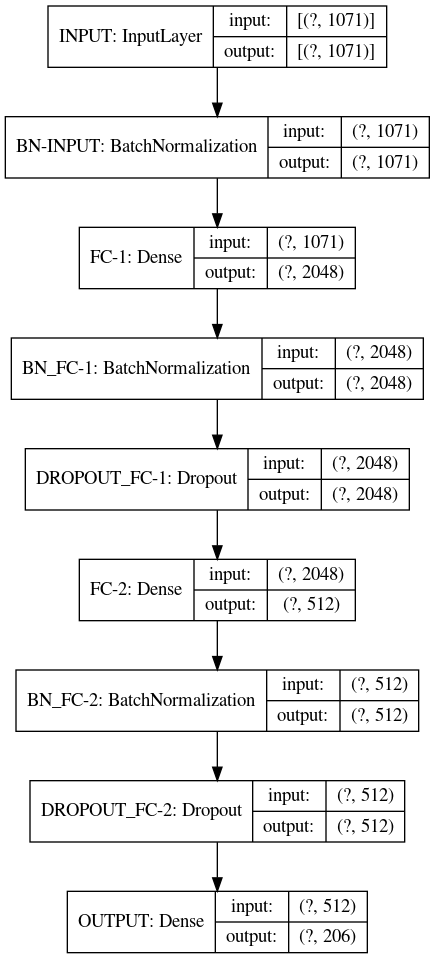

In [36]:
plot_model(model, to_file='/kaggle/working/moa_prediction_model.png', show_shapes=True, show_layer_names=True)

In [37]:
y_pred = 0
y_pred_final = 0
idx = 0

np.random.seed(1)
seeds = np.random.randint(0, 100, size=5)

for seed in seeds:
    
    # Define K-fold cross validation test harness
    kfold = MultilabelStratifiedKFold(n_splits=7, shuffle=True, random_state=seed)
    
    for train, val in kfold.split(Xtrain, Ytrain):

        idx += 1
        print("---------------- Fold {} ----------------".format(idx))

        train_x_tmp, val_x_tmp = Xtrain[train], Xtrain[val]
        train_y_tmp, val_y_tmp = Ytrain[train], Ytrain[val]

        # Create the model
        model = moa_prediction_model(Xtrain.shape[1], Ytrain.shape[1])

        # Compile model to configure the learning process
        model.compile(loss='binary_crossentropy', 
                      optimizer=Lookahead(AdamW(lr=1e-2, 
                                                weight_decay=1e-5, 
                                                clipvalue=700), 
                                          sync_period=10))

        # Early stopping policy
        early = EarlyStopping(monitor="val_loss", mode="min", 
                              restore_best_weights=True, 
                              patience=10, verbose=1)

        # Reduce LR on plateau policy
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, 
                                      min_lr=1e-5, patience=5, 
                                      verbose=1, mode='min')

        # Fit the model
        history = model.fit(x=train_x_tmp, y=train_y_tmp, 
                            batch_size=mini_batch_size, epochs=85, verbose=1,
                            callbacks=[reduce_lr, early], workers=5,
                            validation_data=(val_x_tmp, val_y_tmp))

        # Make predictions
        pred = model.predict(Xtest)
        y_pred += pred

        pred_final = model.predict(Xpredict)
        y_pred_final += pred_final


print("Total #iterations: {}".format(idx))
y_pred /= float(idx)
y_pred_final /= float(idx)

---------------- Fold 1 ----------------
Epoch 1/85
135/135 [==============================] - 1s 8ms/step - loss: 0.3461 - val_loss: 0.1747
Epoch 2/85
135/135 [==============================] - 1s 7ms/step - loss: 0.1335 - val_loss: 0.1123
Epoch 3/85
135/135 [==============================] - 1s 7ms/step - loss: 0.1178 - val_loss: 0.3865
Epoch 4/85
135/135 [==============================] - 1s 7ms/step - loss: 0.1365 - val_loss: 0.0645
Epoch 5/85
135/135 [==============================] - 1s 7ms/step - loss: 0.0582 - val_loss: 0.0490
Epoch 6/85
135/135 [==============================] - 1s 7ms/step - loss: 0.0752 - val_loss: 0.0504
Epoch 7/85
135/135 [==============================] - 1s 8ms/step - loss: 0.0551 - val_loss: 0.0571
Epoch 8/85
135/135 [==============================] - 1s 7ms/step - loss: 0.1390 - val_loss: 0.0721
Epoch 9/85
135/135 [==============================] - 1s 7ms/step - loss: 0.0709 - val_loss: 0.0517
Epoch 10/85
135/135 [==============================] - 1s 7

In [38]:
# Label smoothing
y_pred = np.clip(y_pred, p_min, p_max)
y_pred_final = np.clip(y_pred_final, p_min, p_max)

In [39]:
true_labels = pd.DataFrame(Ytest, columns=train_label_df.columns)
pred_labels = pd.DataFrame(y_pred, columns=train_label_df.columns)
logloss_metric(train_label_df, true_labels, pred_labels)

0.016492138941003275

## Create submission file

In [40]:
pred_labels = pd.DataFrame(y_pred_final, columns=train_label_df.columns)
pred_labels.loc[predict_df['cp_type']=='ctl_vehicle', train_label_df.columns] = 0
print(pred_labels.shape)
pred_labels.head()

(3982, 206)


,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,0.001000,0.001,0.001915,0.015508,0.021545,0.004934,0.002623,0.005574,0.001000,0.016699,...,0.001,0.002258,0.003698,0.002693,0.001162,0.001,0.001169,0.002293,0.003018,0.001571
1,0.001000,0.001,0.001211,0.002659,0.002152,0.001588,0.001084,0.008005,0.004749,0.010807,...,0.001,0.002122,0.001942,0.001000,0.017099,0.001,0.016166,0.001000,0.001431,0.001736
2,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
3,0.001000,0.001,0.001863,0.013270,0.018007,0.003876,0.003456,0.008697,0.001000,0.014241,...,0.001,0.001170,0.002725,0.004337,0.004501,0.001,0.001580,0.002247,0.002083,0.002286
4,0.001885,0.001,0.001827,0.013483,0.018651,0.004574,0.006088,0.002676,0.001000,0.016012,...,0.001,0.001000,0.003533,0.001000,0.001000,0.001,0.001000,0.001522,0.001058,0.002028


In [41]:
submit_df = pd.read_csv("/kaggle/input/lish-moa/sample_submission.csv")
submit_df.loc[:, submit_df.columns != 'sig_id'] = pred_labels
submit_df.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.001000,0.001,0.001915,0.015508,0.021545,0.004934,0.002623,0.005574,0.001000,...,0.001,0.002258,0.003698,0.002693,0.001162,0.001,0.001169,0.002293,0.003018,0.001571
1,id_001897cda,0.001000,0.001,0.001211,0.002659,0.002152,0.001588,0.001084,0.008005,0.004749,...,0.001,0.002122,0.001942,0.001000,0.017099,0.001,0.016166,0.001000,0.001431,0.001736
2,id_002429b5b,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000
3,id_00276f245,0.001000,0.001,0.001863,0.013270,0.018007,0.003876,0.003456,0.008697,0.001000,...,0.001,0.001170,0.002725,0.004337,0.004501,0.001,0.001580,0.002247,0.002083,0.002286
4,id_0027f1083,0.001885,0.001,0.001827,0.013483,0.018651,0.004574,0.006088,0.002676,0.001000,...,0.001,0.001000,0.003533,0.001000,0.001000,0.001,0.001000,0.001522,0.001058,0.002028


In [42]:
submit_df.to_csv("/kaggle/working/submission.csv", index=False)